In [17]:
# default_exp predict

# Predict

> API details.

In [18]:
#export
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import argparse
from time import time
from functools import wraps

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from joblib import Parallel, delayed

import accelerate_simulations.geometry as geom
import accelerate_simulations.preprocess as prep

In [19]:
#export
def timeit(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            print(f"[INFO]\t\t {func.__name__} took: {end_/1000 if end_ > 0 else 0:.2f} s")
    return _time_it

In [20]:
#export
class Predictor:
    def __init__(self, path_model, **config):
        self.config = config
        self.model = self.load_model(path_model) 
    
    def __call__(self, n_samples, circle_radius_range):
        input_fields = self.make_input_fields(n_samples, circle_radius_range)
        pred = self.predict(input_fields)
        return pred
    
    @staticmethod
    @timeit
    def load_model(path):
        return tf.keras.models.load_model(path)

    @timeit
    def predict(self, input_fields):
        return self.model.predict(input_fields)

    @timeit
    def make_input_fields(self, n_samples, circle_radius_range):
        par = Parallel(n_jobs=-1)
        del_func = delayed(self.make_input_field)
        
        input_fields = par(
            del_func(
                np.random.randint(1e6), 
                circle_radius_range,
                self.config
            ) 
            for _ in range(n_samples)
        )

        return np.stack(input_fields, axis=0)

    @staticmethod
    def make_input_field(seed, circle_radius_range, config):
        abstract_geometry = geom.AbstractGeometry(
                config['circle_density'], 
                circle_radius_range, 
                config['box_size'], 
                config['gap'], 
                seed=seed)

        rasterize = geom.GeometryRasterizer(resolution=config['resolution'])
        x, y, raster_image = rasterize(abstract_geometry)

        make_geometric_fields = prep.GeometricFieldMaker(
            config['names_boundary'], 
            geom.element_to_tag, 
            scaling_factor=3)

        input_fields = make_geometric_fields(raster_image, x, y)
        return input_fields


In [21]:
predict = Predictor(
    '../../examples/box_w_aggr/saved_model', 
    post_process_func=lambda x: x*1e-4,
    circle_density=0.9,  
    box_size=(200,200), 
    gap=10,
    resolution=(128,128),
    names_boundary = ['circles_boundaries']
)

load_model took: 1.13 s


In [48]:
pred = predict(100, circle_radius_range=(5,100))

make_input_fields took: 45.75 s
predict took: 2.13 s


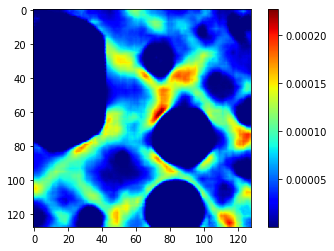

In [49]:
idx = 0

plt.figure()
plt.imshow(np.squeeze(pred[idx]), cmap='jet')
plt.colorbar()

In [62]:
plastic_strains_1 = predict(1000, circle_radius_range=(20,25))

make_input_fields took: 1157.86 s
predict took: 27.52 s


In [63]:
plastic_strains_2 = predict(1000, circle_radius_range=(45,50))

make_input_fields took: 161.28 s
predict took: 26.56 s


In [79]:
#export
def max_per_case(pred):
    return np.max(pred*1e+4, axis=(1,2,3))

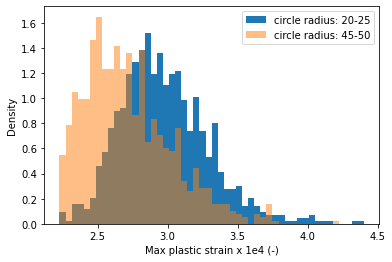

In [82]:
_, bins, _ = plt.hist(max_per_case(plastic_strains_1), bins=50, density=True, color='C0')
plt.hist(max_per_case(plastic_strains_2), bins=bins, color='C1', density=True, alpha=0.5)
plt.legend(['circle radius: 20-25', 'circle radius: 45-50'])
plt.xlabel('Max plastic strain x 1e4 (-)')
plt.ylabel('Density');